<a href="https://www.kaggle.com/code/merveates/cltv-prediction-with-bg-nbd-and-gamma-gamma?scriptVersionId=199086290" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flo-data-20k-csv/flo_data_20k.csv


# Importings

In [2]:
pip install Lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.mode.chained_assignment = None

# Veriyi Anlama

In [5]:
df_ = pd.read_csv("/kaggle/input/flo-data-20k-csv/flo_data_20k.csv")
df = df_.copy()
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.00,1.00,139.99,799.38,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.00,2.00,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.00,2.00,189.97,395.35,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.00,1.00,39.99,81.98,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.00,1.00,49.99,159.99,[AKTIFSPOR]


In [6]:
df.shape

(19945, 12)

In [7]:
df.isnull().sum()

master_id                            0
order_channel                        0
last_order_channel                   0
first_order_date                     0
last_order_date                      0
last_order_date_online               0
last_order_date_offline              0
order_num_total_ever_online          0
order_num_total_ever_offline         0
customer_value_total_ever_offline    0
customer_value_total_ever_online     0
interested_in_categories_12          0
dtype: int64

## Aykırı değerleri baskılamak için gerekli olan outlier_thresholds ve replace_with_thresholds fonksiyonlarının tanımlanması


In [8]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [9]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = round(low_limit,0)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit,0)

>"order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online" değişkenlerinin
aykırı değerlerini baskılama;

In [10]:
columns = ["order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline","customer_value_total_ever_online"]
for col in columns:
    replace_with_thresholds(df, col)

In [11]:
# Her bir müşterinin toplam alışveriş sayısı ve harcaması için yeni değişkenlerinin oluşturulması

df["order_num_total"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["customer_value_total"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]
df.head()


,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,order_num_total,customer_value_total
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.00,1.00,139.99,799.38,[KADIN],5.00,939.37
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.00,2.00,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",21.00,2013.55
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.00,2.00,189.97,395.35,"[ERKEK, KADIN]",5.00,585.32
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.00,1.00,39.99,81.98,"[AKTIFCOCUK, COCUK]",2.00,121.97
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.00,1.00,49.99,159.99,[AKTIFSPOR],2.00,209.98


In [12]:
#date tipine çevirme işlemi
df.info()
date_columns=df.columns[df.columns.str.contains("date")]
df[date_columns]= df[date_columns].apply(pd.to_datetime)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   master_id                          19945 non-null  object 
 1   order_channel                      19945 non-null  object 
 2   last_order_channel                 19945 non-null  object 
 3   first_order_date                   19945 non-null  object 
 4   last_order_date                    19945 non-null  object 
 5   last_order_date_online             19945 non-null  object 
 6   last_order_date_offline            19945 non-null  object 
 7   order_num_total_ever_online        19945 non-null  float64
 8   order_num_total_ever_offline       19945 non-null  float64
 9   customer_value_total_ever_offline  19945 non-null  float64
 10  customer_value_total_ever_online   19945 non-null  float64
 11  interested_in_categories_12        19945 non-null  obj

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   master_id                          19945 non-null  object        
 1   order_channel                      19945 non-null  object        
 2   last_order_channel                 19945 non-null  object        
 3   first_order_date                   19945 non-null  datetime64[ns]
 4   last_order_date                    19945 non-null  datetime64[ns]
 5   last_order_date_online             19945 non-null  datetime64[ns]
 6   last_order_date_offline            19945 non-null  datetime64[ns]
 7   order_num_total_ever_online        19945 non-null  float64       
 8   order_num_total_ever_offline       19945 non-null  float64       
 9   customer_value_total_ever_offline  19945 non-null  float64       
 10  customer_value_total_ever_online  

# CLTV Yapısının Oluşturulması

In [14]:
df["last_order_date"].max()

Timestamp('2021-05-30 00:00:00')

In [15]:
analysis_date = dt.datetime(2021,6,1)

In [16]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,order_num_total,customer_value_total
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.00,1.00,139.99,799.38,[KADIN],5.00,939.37
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.00,2.00,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",21.00,2013.55
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.00,2.00,189.97,395.35,"[ERKEK, KADIN]",5.00,585.32
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.00,1.00,39.99,81.98,"[AKTIFCOCUK, COCUK]",2.00,121.97
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.00,1.00,49.99,159.99,[AKTIFSPOR],2.00,209.98


# BG/NBD

* Recency: The time elapsed since the last purchase (in weeks) (last purchase - first purchase) (specific to the user)
* T: The age of the customer (in weeks) (how long ago the first purchase was made from the analysis date)

# GAMMA GAMMA

* Frequency: Total number of repeat purchases (frequency > 1)
* Monetary: Average revenue per purchase (average)

In [17]:
# customer_id, recency_cltv_weekly, T_weekly, frequency ve monetary_cltv_avg değerlerinin yer aldığı yeni bir cltv dataframe'i oluşturunuz.
cltv_df = pd.DataFrame()

In [18]:
cltv_df["customer_id"] = df["master_id"]
cltv_df["recency_cltv_weekly"] = ((df["last_order_date"]- df["first_order_date"]).dt.days) / 7
cltv_df["T_weekly"] = ((analysis_date - df["first_order_date"]).dt.days)/7
cltv_df["frequency"] = df["order_num_total"]
cltv_df["monetary_cltv_avg"] = df["customer_value_total"] / df["order_num_total"]

In [19]:
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.00,30.57,5.00,187.87
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.86,224.86,21.00,95.88
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.29,78.86,5.00,117.06
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.57,20.86,2.00,60.98
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.14,95.43,2.00,104.99


# BG/NBD Modeli

In [20]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

In [21]:
bgf.fit(cltv_df['frequency'],
        cltv_df['recency_cltv_weekly'],
        cltv_df['T_weekly'])

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 76.17, b: 0.00, r: 3.66>

> 3 ay içerisinde müşterilerden beklenen satın almaları tahmin ediniz ve exp_sales_3_month olarak cltv dataframe'ine ekleyiniz.


In [22]:
cltv_df["exp_sales_3_month"] = bgf.predict(4*3,
                                       cltv_df['frequency'],
                                       cltv_df['recency_cltv_weekly'],
                                       cltv_df['T_weekly'])

> 6 ay içerisinde müşterilerden beklenen satın almaları tahmin ediniz ve exp_sales_6_month olarak cltv dataframe'ine ekleyiniz.


In [23]:
cltv_df["exp_sales_6_month"] = bgf.predict(4*6,
                                       cltv_df['frequency'],
                                       cltv_df['recency_cltv_weekly'],
                                       cltv_df['T_weekly'])

> 3. ve 6. aydaki en çok satın alım gerçekleştirecek 10 kişiyi gösterme


In [24]:
cltv_df.sort_values("exp_sales_3_month",ascending=False)[:10]


,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.71,67.29,52.00,166.22,4.66,9.31
15611,4a7e875e-e6ce-11ea-8f44-000d3a38a36f,39.71,40.00,29.00,165.30,3.37,6.75
8328,1902bf80-0035-11eb-8341-000d3a38a36f,28.86,33.29,25.00,97.44,3.14,6.28
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.57,58.71,31.00,228.53,3.08,6.17
14373,f00ad516-c4f4-11ea-98f7-000d3a38a36f,38.00,46.43,27.00,141.35,3.00,6.00
10489,7af5cd16-b100-11e9-9757-000d3a38a36f,103.14,111.86,43.00,157.11,2.98,5.96
4315,d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,133.14,147.14,49.00,161.85,2.83,5.66
6756,27310582-6362-11ea-a6dc-000d3a38a36f,62.71,64.14,29.00,168.88,2.79,5.59
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.71,13.00,17.00,259.87,2.78,5.56
10536,e143b6fa-d6f8-11e9-93bc-000d3a38a36f,104.57,113.43,40.00,176.20,2.76,5.53


In [25]:
cltv_df.sort_values("exp_sales_6_month",ascending=False)[:10]


,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.71,67.29,52.00,166.22,4.66,9.31
15611,4a7e875e-e6ce-11ea-8f44-000d3a38a36f,39.71,40.00,29.00,165.30,3.37,6.75
8328,1902bf80-0035-11eb-8341-000d3a38a36f,28.86,33.29,25.00,97.44,3.14,6.28
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.57,58.71,31.00,228.53,3.08,6.17
14373,f00ad516-c4f4-11ea-98f7-000d3a38a36f,38.00,46.43,27.00,141.35,3.00,6.00
10489,7af5cd16-b100-11e9-9757-000d3a38a36f,103.14,111.86,43.00,157.11,2.98,5.96
4315,d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,133.14,147.14,49.00,161.85,2.83,5.66
6756,27310582-6362-11ea-a6dc-000d3a38a36f,62.71,64.14,29.00,168.88,2.79,5.59
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.71,13.00,17.00,259.87,2.78,5.56
10536,e143b6fa-d6f8-11e9-93bc-000d3a38a36f,104.57,113.43,40.00,176.20,2.76,5.53


# Gamma Gamma Modeli

In [26]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

In [27]:
ggf.fit(cltv_df['frequency'], cltv_df['monetary_cltv_avg'])
cltv_df["exp_average_value"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                cltv_df['monetary_cltv_avg'])

In [28]:
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.00,30.57,5.00,187.87,0.97,1.95,193.63
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.86,224.86,21.00,95.88,0.98,1.97,96.67
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.29,78.86,5.00,117.06,0.67,1.34,120.97
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.57,20.86,2.00,60.98,0.70,1.40,67.32
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.14,95.43,2.00,104.99,0.40,0.79,114.33


> 3 ve 6 aylık CLTV hesaplayınız ve cltv ismiyle dataframe'e ekleyiniz.

In [29]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency_cltv_weekly'],
                                   cltv_df['T_weekly'],
                                   cltv_df['monetary_cltv_avg'],
                                   time=3,
                                   freq="W",
                                   discount_rate=0.01)

In [30]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency_cltv_weekly'],
                                   cltv_df['T_weekly'],
                                   cltv_df['monetary_cltv_avg'],
                                   time=6,
                                   freq="W",
                                   discount_rate=0.01)

In [31]:
cltv_df["cltv"] = cltv

In [32]:
cltv.head()

0   395.73
1   199.43
2   170.22
3    98.95
4    95.01
Name: clv, dtype: float64

In [33]:
# CLTV değeri en yüksek 20 kişiyi gözlemleyiniz.
cltv_df.sort_values("cltv",ascending=False)[:20]

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.86,7.86,4.00,1401.80,1.09,2.19,1449.06,3327.78
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.14,13.14,11.00,758.09,1.97,3.94,767.36,3172.39
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.71,101.00,7.00,1106.47,0.72,1.44,1127.61,1708.98
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.29,74.57,16.00,501.87,1.57,3.13,506.17,1662.61
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.71,67.29,52.00,166.22,4.66,9.31,166.71,1628.89
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.43,34.43,8.00,601.23,1.27,2.53,611.49,1623.81
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.29,9.43,2.00,862.69,0.79,1.59,923.68,1538.86
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.71,13.00,17.00,259.87,2.78,5.56,262.07,1529.23
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.57,58.71,31.00,228.53,3.08,6.17,229.61,1485.82
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,14.86,15.57,3.00,743.59,0.87,1.74,778.05,1423.00


# CLTV'ye Göre Segmentlerin Oluşturulması

In [34]:
cltv_df["cltv_segment"] = pd.qcut(cltv_df["cltv"], 4, labels=["D", "C", "B", "A"])
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv,cltv_segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.00,30.57,5.00,187.87,0.97,1.95,193.63,395.73,A
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.86,224.86,21.00,95.88,0.98,1.97,96.67,199.43,B
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.29,78.86,5.00,117.06,0.67,1.34,120.97,170.22,B
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.57,20.86,2.00,60.98,0.70,1.40,67.32,98.95,D
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.14,95.43,2.00,104.99,0.40,0.79,114.33,95.01,D


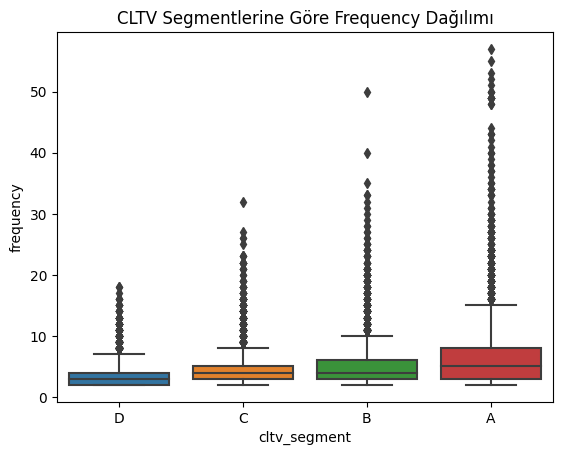

In [35]:
sns.boxplot(x="cltv_segment", y="frequency", data=cltv_df)
plt.title("CLTV Segmentlerine Göre Frequency Dağılımı")
plt.show()